In [1]:
import pandas as pd
import biom
import qiime2
import numpy as np
import os
import skbio

import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection


from qiime2.plugins.emperor.actions import (plot, biplot)
from qiime2.plugins.diversity.actions import (beta_phylogenetic, pcoa, beta)
from qiime2.plugins.feature_table.actions import (rarefy, filter_samples)

from qiime2.plugins.taxa.actions import collapse

import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex

plt.rcParams['svg.fonttype'] = 'none'

import seaborn as sns

# from skbio.stats.ordination import pcoa
from scipy import stats
%matplotlib inline



### All we will need is a table and associated metadata

In [2]:
qtab = qiime2.Artifact.load('data/table.qza')
meta = pd.read_csv('data/metadata.tsv', sep='\t')
meta.head()

,sample_name,metab-sample-id,age_units,anonymized_name,cage_food_consumption_g,cage_location,cage_notes,cage_number,collection_timestamp,description,...,physical_specimen_location,qiita_study_id,sample_type,scientific_name,sex,taxon_id,title,weight_units,age_bin,age_match
0,11829.A45.179.2,A45_179_2,weeks,A45.179.2,44.2,On shelf,NaN,A45,4/6/18 11:30,Mouse 179 stool collection 2 of 21,...,UCSDMI,11829.0,stool,mouse gut metagenome,male,410661.0,10 week IH and IC,g,12.0,10.5
1,11829.A37.150.21,A37_150_21,weeks,A37.150.21,52.7,In chamber,NaN,A37,6/12/18 10:00,Mouse 150 stool collection 21 of 21,...,UCSDMI,11829.0,stool,mouse gut metagenome,male,410661.0,10 week IH and IC,g,20.0,20.0
2,11829.A35.140.2,A35_140_2,weeks,A35.140.2,37.2,On shelf,Fighting cage,A35,4/6/18 12:00,Mouse 140 stool collection 2 of 21,...,UCSDMI,11829.0,stool,mouse gut metagenome,male,410661.0,10 week IH and IC,g,12.0,10.5
3,11829.A42.168.11,A42_168_11,weeks,A42.168.11,48.2,In chamber,NaN,A42,5/8/18 11:00,Mouse 168 stool collection 11 of 21,...,UCSDMI,11829.0,stool,mouse gut metagenome,male,410661.0,10 week IH and IC,g,16.0,15.0
4,11829.A41.166.2,A41_166_2,weeks,A41.166.2,41.8,In chamber,NaN,A41,4/6/18 11:00,Mouse 166 stool collection 2 of 21,...,UCSDMI,11829.0,stool,mouse gut metagenome,male,410661.0,10 week IH and IC,g,12.0,10.5


### Examine how many observations at each timepoint for each condition we have

We are interested in how IH (intermittent hypoxia) or IC (hypercapnia) alter the microbiome. Our time variable will be given by "age_match" and our group variable will be IH vs. IC vs. Air (control) which in the metadata is called "exposure_type"

In [3]:
pd.DataFrame(meta[['age_match', 'exposure_type']].value_counts()).sort_values(by='age_match')

count
age_match exposure_type       
10.0      IC                16
          Air               15
          IH                15
10.5      IC                16
          IH                16
          Air               15
15.0      IC                16
          IH                16
          Air               15
20.0      IC                16
          IH                16
          Air               13

### Visualize each time point in 3d
Use an appropriate distance metric to generate an ordination. If you are unfamiliar with this step please consult the RPCA tutorial on the gemelli github page, which gives a more detailed explanation of how the RPCA distance metric works and how to use it. Your downstream results will be heavily impacted based on which distance metric you choose to use.

In [4]:
# USE YOUR FAVORITE DISTANCE METRIC TO GENERATE DISTANCE MATRIX & ORDINATION
from qiime2.plugins.gemelli.actions import rpca
result = rpca(qtab)
result.biplot.save(f'data/rpca-biplot.qza')
result.distance_matrix.save(f'data/rpca-dmat.qza')

'data/rpca-dmat.qza'

In [5]:
# QIIME2 WILL AUTOMATICALLY DO THIS WHEN I REPLACE W PLUGIN
tab = qtab.view(biom.Table)
ord = result.biplot.view(skbio.OrdinationResults)

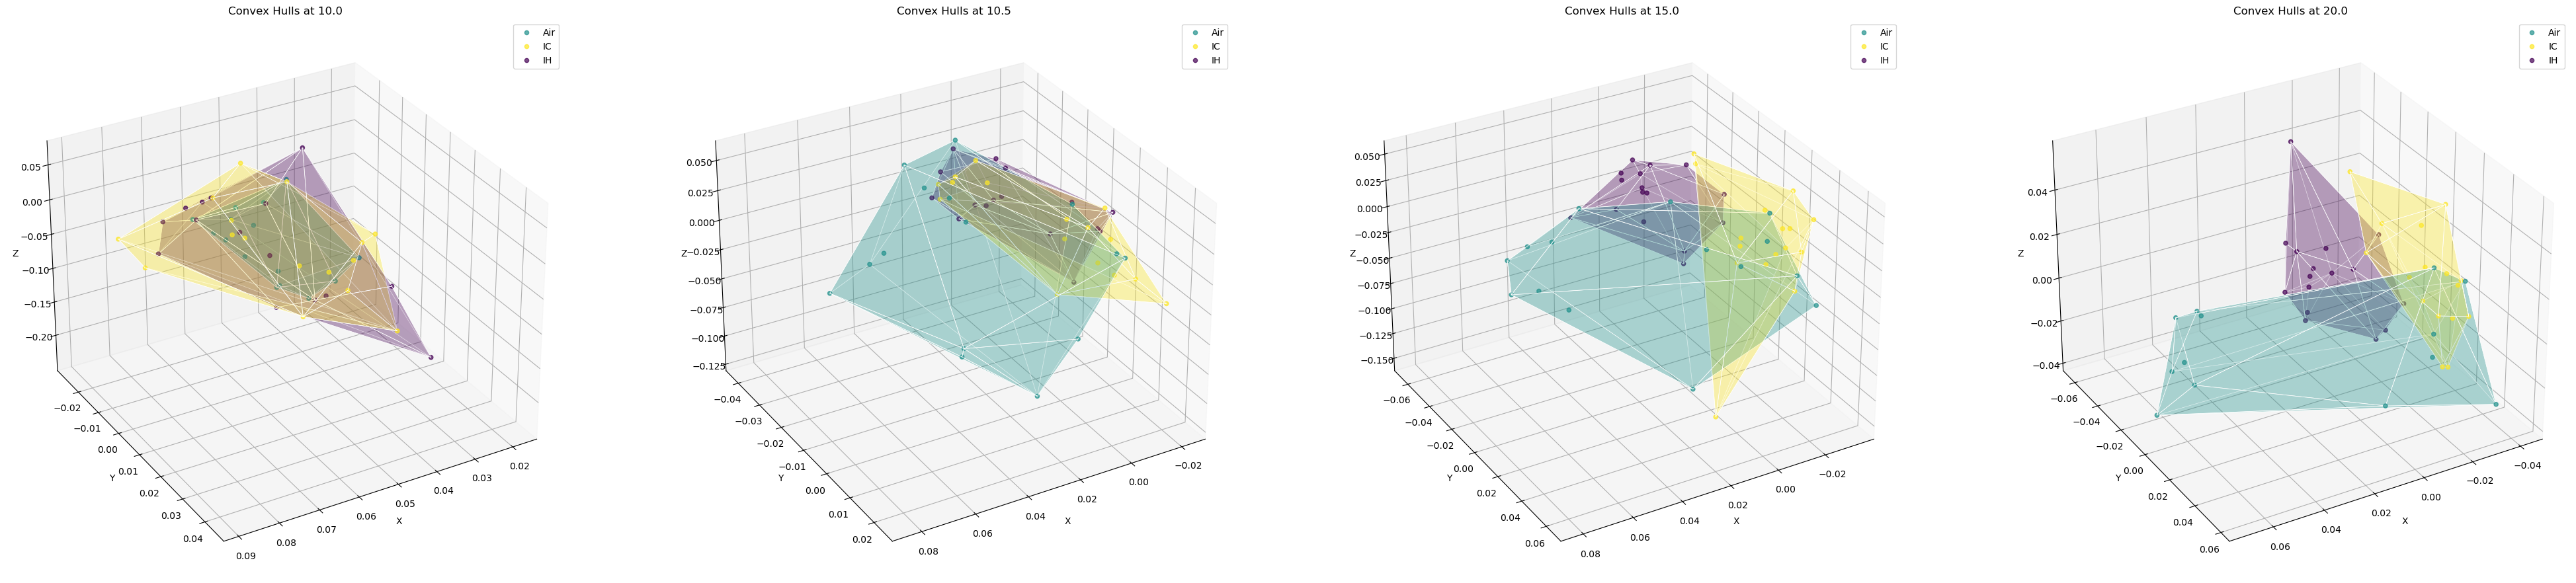

In [10]:
TIME_COL = 'age_match'
GROUP_COL = 'exposure_type'
ID = 'sample_name'
quiet = True
        
def filter_ids(ord, meta):
    """ Matches metadata to ordination. Returns ord, meta """
    
    ids = list(set(ord.samples.index) & set(meta[ID]))
    if len(ids) == 0:
        raise KeyError("No matching ids found between metadata and ordination.")
    
    ord = ord.samples.loc[ids]
    meta = meta.set_index(ID).loc[ids].reset_index()
    
    return ord, meta

def get_colors(meta, GROUP_COL, base_map='viridis'):
    
    groups = meta[GROUP_COL].unique()
    num_colors = len(groups)
    
    if base_map == 'viridis':
        cmap = plt.cm.viridis
    if base_map == 'tab10':
        cmap = plt.cm.tab10
        
    vcolors = cmap(np.linspace(0, 1, num_colors))
    hcolors = [rgb2hex(color) for color in vcolors]

    colors = {groups[i]:hcolors[i] for i in range(len(groups))}
    return colors


def match_ids(skb, ids):
    """ Input skb ordination, ids. Output overlaps as list"""
    matched_ids = list(set(skb.index) & set(ids))
    
    if len(matched_ids) < 3:
        raise ValueError('Error in match_ids. Too few points.')
    
    return matched_ids


def add_hull(points, simplex, color, ax):
    """ Adds hull around points on ax
    input: points, color, ax"""
    
    log('add_hull')
    simplex_points = points[simplex]
    poly = Poly3DCollection([simplex_points], alpha=0.2, facecolor=color)
    ax.add_collection3d(poly)
    edges = [[simplex_points[i], simplex_points[j]] for i, j in [(0, 1), (1, 2), (2, 0)]]
    edge_lines = Line3DCollection(edges, colors='white', linewidths=0.5)
    ax.add_collection3d(edge_lines)


def get_site_ids(site, time):
    s = meta[GROUP_COL] == site
    t = meta[TIME_COL] == time

    return list(meta[s & t][ID])


def get_ordination(qfile):
    """ qfile .qza returns ordinationresults object"""
    skb = qiime2.Artifact.load(qfile).view(skbio.OrdinationResults)
    skb = skb.samples.T[:3].T
    return skb


def get_points(skb, matched_ids):
    """ skb (ordination), matched_ids (list)"""
    return skb.loc[matched_ids].to_numpy()


def get_hull(site_points, site, time):
    log(f'get_hull {site} {time}')

    try:
        return ConvexHull(site_points)
    except:
        print(f'Error with convex hulls {site} {time}')
        return None


def draw_points_hull(site_points, site_hull, color, label, ax):
    log(f'draw_points_hull')

    ax.scatter(
        site_points[:, 0], 
        site_points[:, 1],
        site_points[:, 2],
        color=color,
        alpha=0.7,
        label=label)

    for simplex in site_hull.simplices:
        add_hull(site_points, simplex, color, ax)


def make_points_hull(site, skb, color, time, ax, subset):

    log(f'make_points_hull {site} {time}')
    ids = get_site_ids(site, time)
    matched_ids = match_ids(skb, ids)
    
    if not subset == None:
        matched_ids = match_ids(skb, subset)

    site_points = get_points(skb, matched_ids)

    site_hull = get_hull(site_points, site, time)

    if not site_hull == None:
        draw_points_hull(site_points, site_hull, color, site, ax)


def log(s):
    if not quiet:
        print(s)

def plot_hulls(skb, times, body_sites, axis=True,
               save=True, rotation=45, elev=30, subset=None):
    """ qfile must end in -biplot.qza """
    log('plotting hulls')
    
    times = sorted(times)

    # Configure plot
    scale = 50
    fig = plt.figure(figsize=(scale, scale))
    ncol = len(times)
    for lab, what_time in enumerate(times):

        ax = fig.add_subplot(1, ncol, lab+1, projection='3d')
        for site in body_sites:

            color = colors[site]
            label = site
            make_points_hull(site, skb, color, what_time, ax, subset=subset)

        # Decorate plot
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        ax.legend()

        if not axis:
            ax.axis('off')
        
        # ax.set_zlim([-.06,0.1])
        # ax.set_ylim([-.05,0.9])
        # ax.set_xlim([-.07,0.07])

        ax.view_init(elev=elev, azim=rotation)  # Adjust these angles as desired

        # Show the plot
        plt.title(f"Convex Hulls at {what_time}")
        # ncol+=1
    plt.show()
   
   
ord = result.biplot.view(skbio.OrdinationResults)
ord, meta = filter_ids(ord, meta)
colors = get_colors(meta, GROUP_COL)

def get_times(meta, TIME_COL):
    return sorted(list(meta[TIME_COL].unique()))

def get_groups(meta, GROUP_COL):
    return sorted(list(meta[GROUP_COL].unique()))

times = get_times(meta, TIME_COL)
sites = get_groups(meta, GROUP_COL)

plot_hulls(ord, times, sites, axis=True, save=False, rotation=60)



### Generate Convex Hull calculations dataframe and subsample by time and group

In [11]:
import random
import warnings

GROUP_COL = 'exposure_type'
TIME_COL = 'age_match'

class SubsampledCH:
    
    def __init__(self):
        self.vols = []
        self.areas = []
        self.times = []
        self.npoints = []
        self.categ = []
        self.iter = []
        self.indiv = []
        
def get_hull(ord, ids, ndim):
    coords = ord.loc[ids].values[:, :ndim]
    return ConvexHull(coords)
        
        
def subsample_ids(group, n):
    ids = list(group.index)
    return random.sample(ids, n)


def find_n_subsamples(groups):
    smallest_n = min([len(group) for g, group in groups])
    return smallest_n - 1 


def df_from_ch(ch, TIME_COL, GROUP_COL):

    all_hulls = pd.DataFrame({
        TIME_COL: ch.times,
        GROUP_COL: ch.categ,
        'convexhull_volume': ch.vols,
        'convexhull_area': ch.areas,
        'npoints': ch.npoints,
        'iteration': ch.iter,
        'individual': ch.indiv,
    })
    return all_hulls


def ch_by_groups(groups, n_subsamples, ord, ch, i, ndim=3, time=True):
            
    for g, group in groups:
        group.set_index('sample_name', inplace=True)
        
        if n_subsamples != None:
            ids = subsample_ids(group, n_subsamples)
        else:
            ids = list(group.index)

        if len(ids) <= 3:
            warnings.warn(f"Not enough samples for this group. Skipping {g}")
            continue

        c_hull = get_hull(ord, ids, ndim)
        log(c_hull.volume)
        ch.vols.append(c_hull.volume)
        ch.areas.append(c_hull.area)
        ch.npoints.append(n_subsamples)
        ch.iter.append(f'iter-{i}')
        
        if time:
            ch.times.append(g[1])
            ch.categ.append(g[0])
            ch.indiv.append('not applicable')
        else:
            ch.times.append(None)
            ch.categ.append(list(group[GROUP_COL])[0])
            ch.indiv.append(g)

    return ch


def generate_all_hulls(meta, ord, GROUP_COL, TIME_COL, 
                       n_subsamples=None,
                       n_iters=10,
                       ndim=3):
    
    groups = meta.groupby([GROUP_COL, TIME_COL])
   
    if n_subsamples == None:
        n_subsamples = find_n_subsamples(groups)
    
    ch = SubsampledCH()
    
    for i in range(n_iters):
        
        ch = ch_by_groups(groups, n_subsamples, ord, ch, i)
    
    all_hulls = df_from_ch(ch, TIME_COL, GROUP_COL)
    return all_hulls

/Users/daniperry/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/daniperry/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/daniperry/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/daniperry/anaconda3/envs/qii

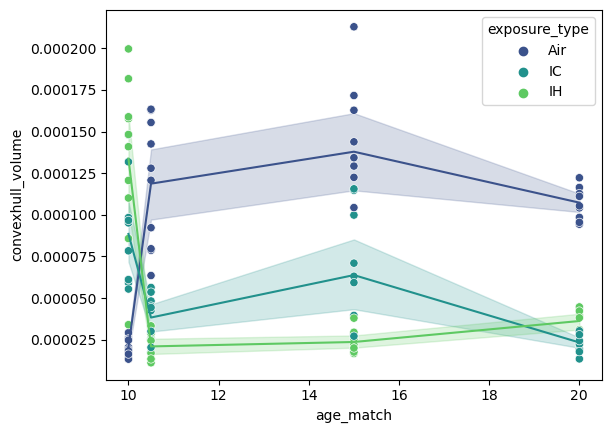

In [12]:
def plot_subsampled_hulls(all_hulls, TIME_COL, GROUP_COL, palette='viridis'):
    
    x=TIME_COL
    y='convexhull_volume'
    hue=GROUP_COL
    data=all_hulls
    sns.lineplot(
        data=data,
        x=x,
        y=y,
        hue=hue,
        legend=False,
        palette=palette
    )
    sns.scatterplot(data=data, x=x, y=y, hue=hue,
                    palette=palette)
    plt.show()


all_hulls = generate_all_hulls(
    meta, ord, GROUP_COL, TIME_COL, n_subsamples=10)

plot_subsampled_hulls(all_hulls, TIME_COL, GROUP_COL)